In [ ]:
# preliminary-analysis-2024-speed-bursts.ipynb
#
# Bryan Daniels
# 2024/5/23
#
# Can bursts of speed by individual bees be connected to comb-building?
#
# Builds from preliminary-analysis-2024-comb-building.ipynb
#

In [1]:
import pandas as pd
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
%matplotlib inline
from toolbox import defaultFigure
defaultFigure.setDefaultParams()
from toolbox import gifsicle
from importlib import reload  
import random
import cProfile
from tqdm import tqdm

In [2]:
# import stuff from jacob davidson's github repository: https://github.com/jacobdavidson/bees_drones_2019data
from bees_drones_2019data import displayfunctions as bp  # 'bee plots'
from bees_drones_2019data import datafunctions as dfunc
from bees_drones_2019data import definitions_2019 as bd
dfunc.init(bd) 
bp.init(bd)
bd.year

2019

In [18]:
import time_functions_2019 as tf

# Load data

The days with festoons are roughly (1) between day 4 and 20 and (2) between day 46 and 65

In [7]:
days_to_load = np.arange(0,10) #[4,]

## Load 5-minute behavioral data

In [3]:
# data from 2019: https://zenodo.org/records/7298798
behavioral_data_dir = '../Data/240329/df_day5min/'

In [8]:
dfList = [ pd.read_hdf('{}df_day5min_{:03d}.hdf'.format(behavioral_data_dir,daynum)) for daynum in days_to_load ]
dfFiveMinute = pd.concat(dfList)

In [102]:
# deal with cohort information

# add cohort names to the dataframe
dfFiveMinute['Cohort name'] = [ bd.cohort_names[int(cid)] for cid in dfFiveMinute['Cohort ID'] ]

# define mapping from bee id to cohort name
bee_cohort_dict = dict([ (int(uid),dfFiveMinute[dfFiveMinute['Bee unique ID']==uid]['Cohort name'].iloc[0]) \
                         for uid in dfFiveMinute['Bee unique ID'].unique() ])

In [47]:
divisions_per_day_five_min = 24*60/5

# Find speed bursts

## at 5 minute resolution

As computed in the section `Data processing to calculate metrics` in `Data processing - 1 - metrics and dataframes.ipynb`, speeds in `dfFiveMinutes` are in units of pixels per second.  Observations separated by >1 second are filtered out.

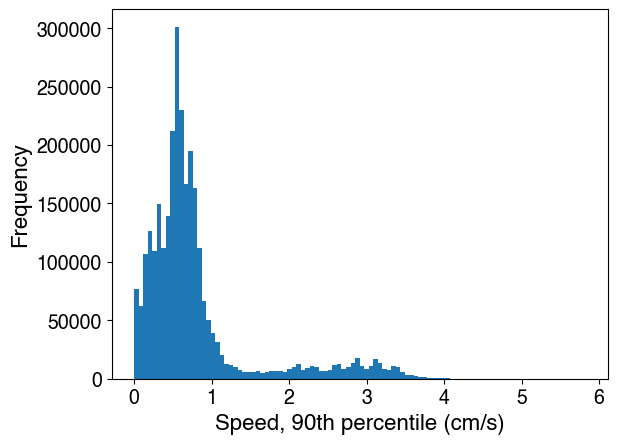

In [10]:
pixels_per_cm = 80
(dfFiveMinute['Speed 90th quantile']/pixels_per_cm).plot.hist(bins=100)
plt.xlabel('Speed, 90th percentile (cm/s)');

In [14]:
# We will define speed bursts for now as 90th percentile speed > 1.5 cm/s
speed_thresh_cmps = 1.5 # cm/s
speed_thresh = speed_thresh_cmps * pixels_per_cm # pixels/s

In [54]:
def state_matrix(df,col,divisions_per_day):
    """
    Takes a dataframe with columns `Bee unique ID`, `Day number`, and `timedivision`. (e.g. from a `df_day5min` file)

    Returns a dataframe indexed by bee id and with columns corresponding to time, with each element
    corresponding to the column `col` of the input dataframe.

    A given time division is included if (and only if) any data are available for that time division.
    A given bee is included if (and only if) any data are available for that bee at any time.
    """
    assert(type(col)==str)

    # we will build lists of times and column_data
    column_data_list,times = [],[]
    
    days = df['Day number'].unique()
    days.sort()
    # loop over days
    for daynum in days:
        df_day = df[df['Day number']==daynum]
        timedivisions = df_day['timedivision'].unique()
        timedivisions.sort()
        # loop over time divisions within a given day
        for timedivision in timedivisions:
            df_day_time = df_day[df_day['timedivision']==timedivision]
            
            # construct column of data for the given time
            column_data_list.append( df_day_time.set_index('Bee unique ID')[col] )

            # convert time division to an absolute time
            times.append(tf.timediv_to_datetime(int(daynum),timedivision,divisions_per_day))

    return pd.DataFrame(column_data_list,index=times).T

In [58]:
# Make binary state matrix (bee x timedivision)
speed_mat = state_matrix(dfFiveMinute,'Speed 90th quantile',divisions_per_day_five_min)

In [59]:
speed_mat

,2019-06-05 00:00:00,2019-06-05 00:05:00,2019-06-05 00:10:00,2019-06-05 00:15:00,2019-06-05 00:20:00,2019-06-05 00:25:00,2019-06-05 00:30:00,2019-06-05 00:35:00,2019-06-05 00:40:00,2019-06-05 00:45:00,...,2019-06-14 23:10:00,2019-06-14 23:15:00,2019-06-14 23:20:00,2019-06-14 23:25:00,2019-06-14 23:30:00,2019-06-14 23:35:00,2019-06-14 23:40:00,2019-06-14 23:45:00,2019-06-14 23:50:00,2019-06-14 23:55:00
Bee unique ID,,,,,,,,,,,,,,,,,,,,,
4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57.078893,56.793289,53.615082,59.997478,34.117821,9.558522,47.847092,57.706152,60.550374,37.013693
9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2621.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.242641,NaN,6.000000,6.708204,15.297059,34.205263,18.000000,31.974548,25.455844,40.092262
2622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,3.000000,9.000000,4.242641,12.000000,9.000000,222.151970,9.000000,12.000000,222.991031


In [111]:
# limit to non-drone bees
non_drone_cohorts = [ name for name in bd.cohort_names if not name.endswith('_drones') ]
non_drone_bees = [ uid for uid in bee_cohort_dict \
                   if bee_cohort_dict[uid] in non_drone_cohorts ]
print("Out of {} total bees, {} come from non-drone cohorts.".format(len(bee_cohort_dict),len(non_drone_bees)))

Out of 2056 total bees, 1864 come from non-drone cohorts.


In [ ]:
# TO DO:
# - color NaN differently than False in the below plot
# - are the quiescent vertical stripes to be believed?
# - put start of comb-building festoon on this plot
# - (do we need to look at data with finer time resolution, e.g. 1 minute?)
# - do bees just starting to festoon have a recent history of higher speeds?

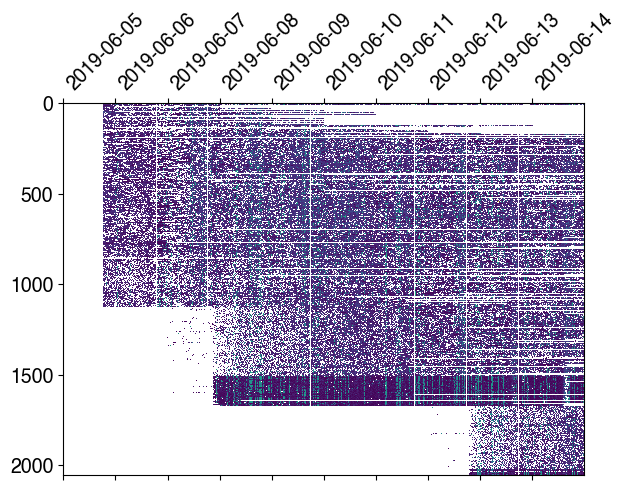

In [160]:
plt.matshow(speed_mat)
skipx = 288 # 288 corresponds to ticks at midnight each day
plt.xticks(range(speed_mat.shape[1])[::skipx], 
           [t.date() for t in speed_mat.columns[::skipx]],rotation=45,ha='left');

In [184]:
fig = plt.figure(figsize=(10,7),dpi=1000)

# show binarized speed matrix
m = speed_mat.loc[non_drone_bees]>speed_thresh
plt.matshow(m,fignum=fig.number)
divisions_per_day = int(divisions_per_day_five_min)
skipx = divisions_per_day # corresponds to ticks at midnight each day
plt.xticks(range(m.shape[1])[::skipx], 
           [t.date() for t in m.columns[::skipx]],rotation=45,ha='left');

# draw vertical lines corresponding to festoon start
just_before_festoon_start,just_after_festoon_start = 4.60,4.65 # days (see preliminary-analysis-2024-comb-building.ipynb)
plt.vlines(just_before_festoon_start*divisions_per_day,0,m.shape[0],color='w',lw=0.5)
plt.vlines(just_after_festoon_start*divisions_per_day,0,m.shape[0],color='w',lw=0.5)
plt.axis(ymin=m.shape[0],ymax=0)

plt.subplots_adjust(bottom=0.05,top=0.5)
plt.savefig('240524_preliminary_speed_burst_data.pdf')

In [188]:
# convert festoon start time to datetime format
festoon_start_daynum = 4
just_before_festoon_start_datetime = tf.timediv_to_datetime(festoon_start_daynum,
                       (just_before_festoon_start-festoon_start_daynum)*divisions_per_day,
                       divisions_per_day)
just_after_festoon_start_datetime = tf.timediv_to_datetime(festoon_start_daynum,
                       (just_after_festoon_start-festoon_start_daynum)*divisions_per_day,
                       divisions_per_day)

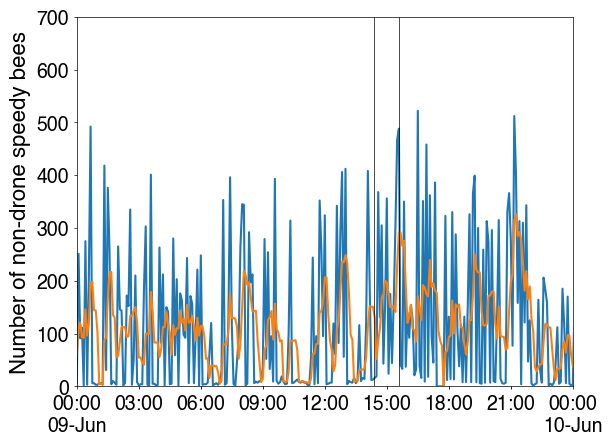

In [192]:
# plot speed sum and rolling average speed sum
(speed_mat.loc[non_drone_bees]>speed_thresh).sum(axis=0).plot()
(speed_mat.loc[non_drone_bees]>speed_thresh).sum(axis=0).rolling(5).mean().plot()

# vertical lines at festoon start
plt.vlines(just_before_festoon_start_datetime,0,700,color='k',lw=0.5)
plt.vlines(just_after_festoon_start_datetime, 0,700,color='k',lw=0.5)
plt.axis(ymin=0,ymax=700)

# fiddle with plot
plt.ylabel('Number of non-drone speedy bees')
plt.axis(xmin=speed_mat.columns[288*4],xmax=speed_mat.columns[288*5])
defaultFigure.makePretty()

In [12]:
# restrict to bees that at some point join the festoon
festoon_sum = dfFiveMinute.groupby('Bee unique ID').sum()['Festoon']
festooner_bees = [ int(uid) for uid in festoon_sum[festoon_sum > 0].index ]
dfFiveMinute_festooners = dfFiveMinute[dfFiveMinute['Bee unique ID'].isin(festooner_bees)]
print("There are {} bees that festoon at some point, out of a total {} bees.".format(len(festooner_bees),
                                                                                     len(dfFiveMinute['Bee unique ID'].unique())))

There are 1595 bees that festoon at some point, out of a total 2056 bees.
